# Intestinal organoid differentiation - DPT

Construct diffusion pseudotime on scEU-seq organoid data.

## Library imports

In [1]:
import os
import sys

import pandas as pd
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv

from cr2 import plot_states, running_in_notebook

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
sc.settings.verbosity = 3
scv.settings.verbosity = 3
cr.settings.verbosity = 2

In [3]:
scv.settings.set_figure_params("scvelo")

In [4]:
SAVE_FIGURES = False

if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "labeling_kernel", exist_ok=True)

## Data loading

In [5]:
adata = sc.read(DATA_DIR / "sceu_organoid" / "processed" / "preprocessed.h5ad")
adata

AnnData object with n_obs × n_vars = 3452 × 2000
    obs: 'experiment', 'labeling_time', 'cell_type', 'som_cluster_id', 'cell_type_merged', 'initial_size', 'n_counts'
    var: 'ensum_id', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_paper'
    varm: 'PCs'
    layers: 'labeled', 'total', 'unlabeled'
    obsp: 'connectivities', 'distances'

## Data preprocessing

In [6]:
adata.obs["cell_type_merged"] = adata.obs["cell_type"].copy()
adata.obs["cell_type_merged"].replace({"Enteroendocrine cells": "Enteroendocrine progenitors"}, inplace=True)

celltype_to_color = dict(zip(adata.obs["cell_type"].cat.categories, adata.uns["cell_type_colors"]))
adata.uns["cell_type_merged_colors"] = list(
    {cell_type: celltype_to_color[cell_type] for cell_type in adata.obs["cell_type_merged"].cat.categories}.values()
)

In [7]:
adata.layers["labeled_smoothed"] = csr_matrix.dot(adata.obsp["connectivities"], adata.layers["labeled"]).A
adata.layers["unlabeled_smoothed"] = csr_matrix.dot(adata.obsp["connectivities"], adata.layers["unlabeled"]).A
adata.layers["total_smoothed"] = csr_matrix.dot(adata.obsp["connectivities"], adata.layers["total"]).A

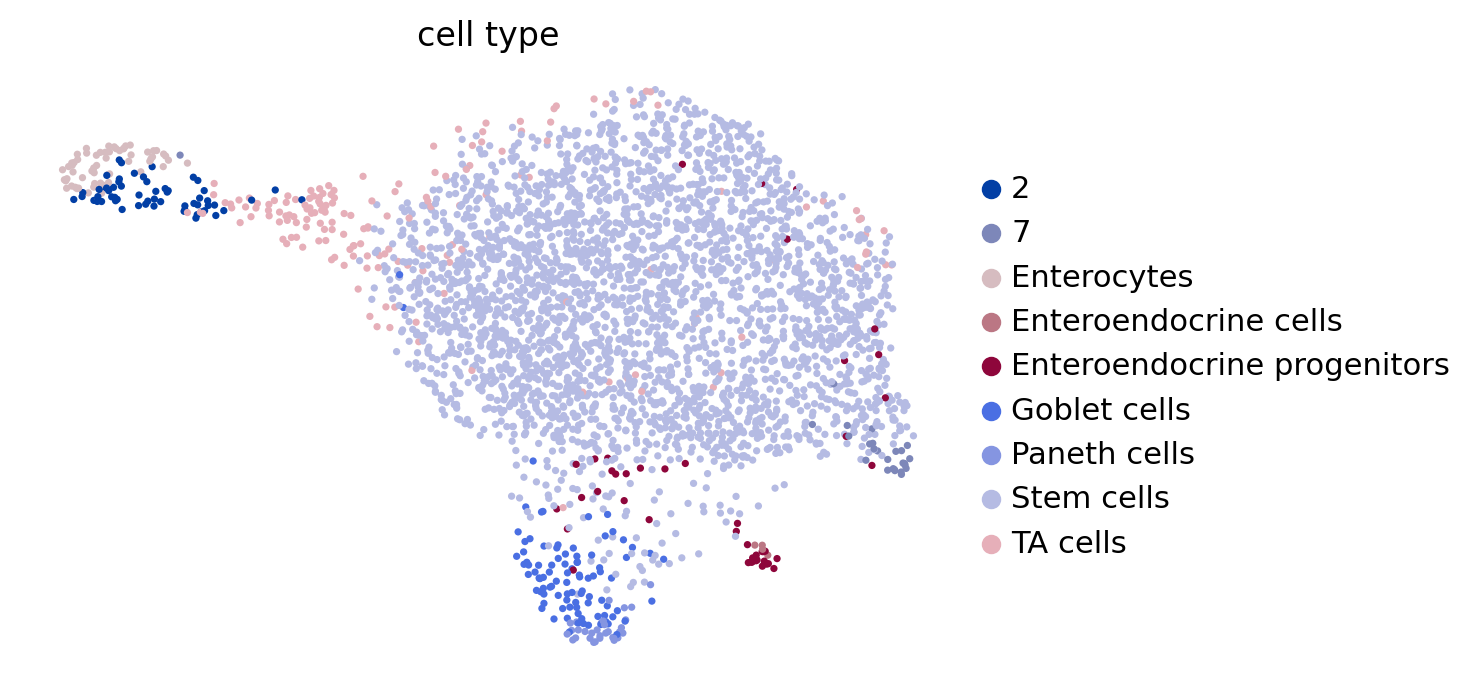

In [8]:
if running_in_notebook():
    scv.pl.scatter(adata, basis="umap", color="cell_type", legend_loc="right")

## Parameter inference

In [9]:
alpha = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "alpha.csv", index_col=0)
alpha.index = alpha.index.astype(str)
adata.layers["transcription_rate"] = alpha.loc[adata.obs_names, adata.var_names]

gamma = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "gamma.csv", index_col=0)
gamma.index = gamma.index.astype(str)
adata.layers["degradation_rate"] = alpha.loc[adata.obs_names, adata.var_names]

## Velocity

In [10]:
adata.layers["velocity_labeled"] = (alpha - gamma * adata.layers["labeled_smoothed"]).values

## CellRank

In [11]:
vk = cr.kernels.VelocityKernel(adata, xkey="labeled_smoothed", vkey="velocity_labeled").compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck

Computing transition matrix using `'deterministic'` model


  0%|          | 0/3452 [00:00<?, ?cell/s]

Using `softmax_scale=2.4573`


  0%|          | 0/3452 [00:00<?, ?cell/s]

    Finish (0:00:06)
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


### Estimator analysis

In [12]:
estimator = cr.estimators.GPCCA(combined_kernel)

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


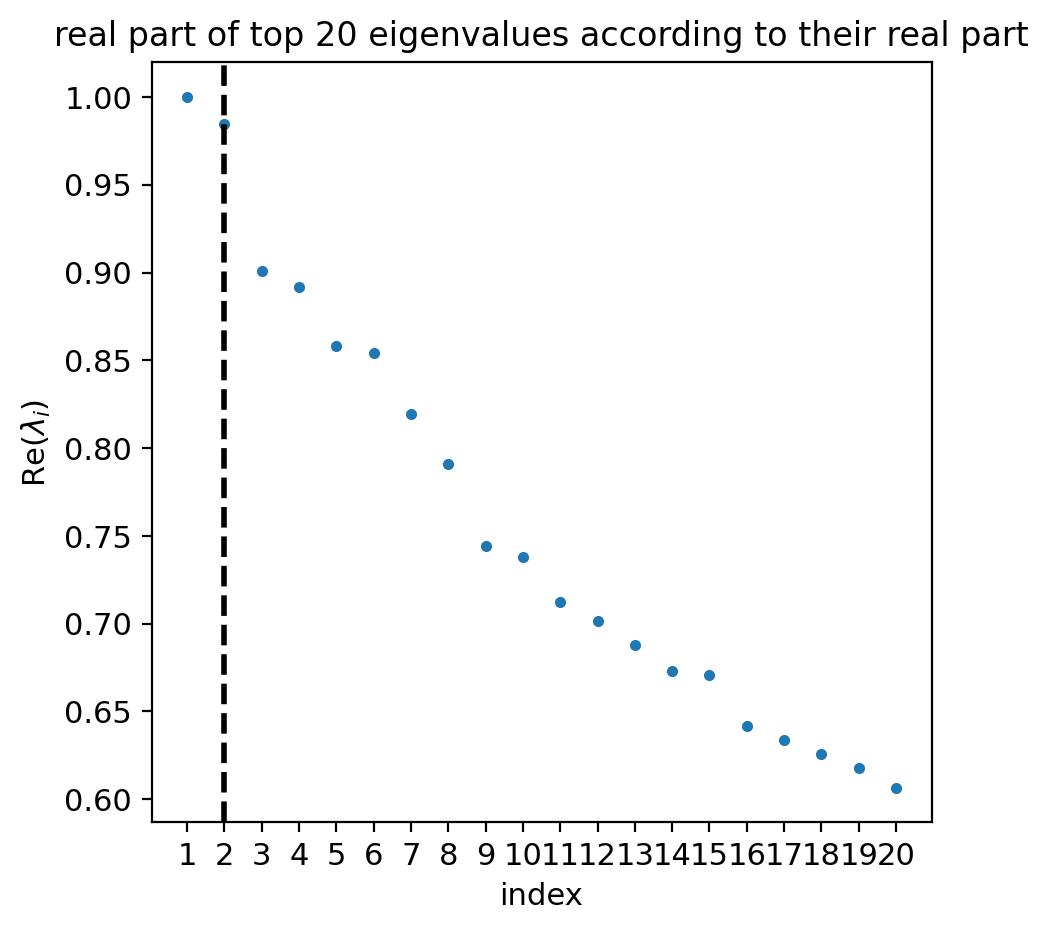

In [13]:
estimator.compute_schur(n_components=20)
if running_in_notebook():
    estimator.plot_spectrum(real_only=True)

#### Macrostates

In [14]:
estimator.compute_macrostates(n_states=12, cluster_key="cell_type")

Computing `12` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:05)


GPCCA[kernel=(0.8 * VelocityKernel[n=3452] + 0.2 * ConnectivityKernel[n=3452]), initial_states=None, terminal_states=None]

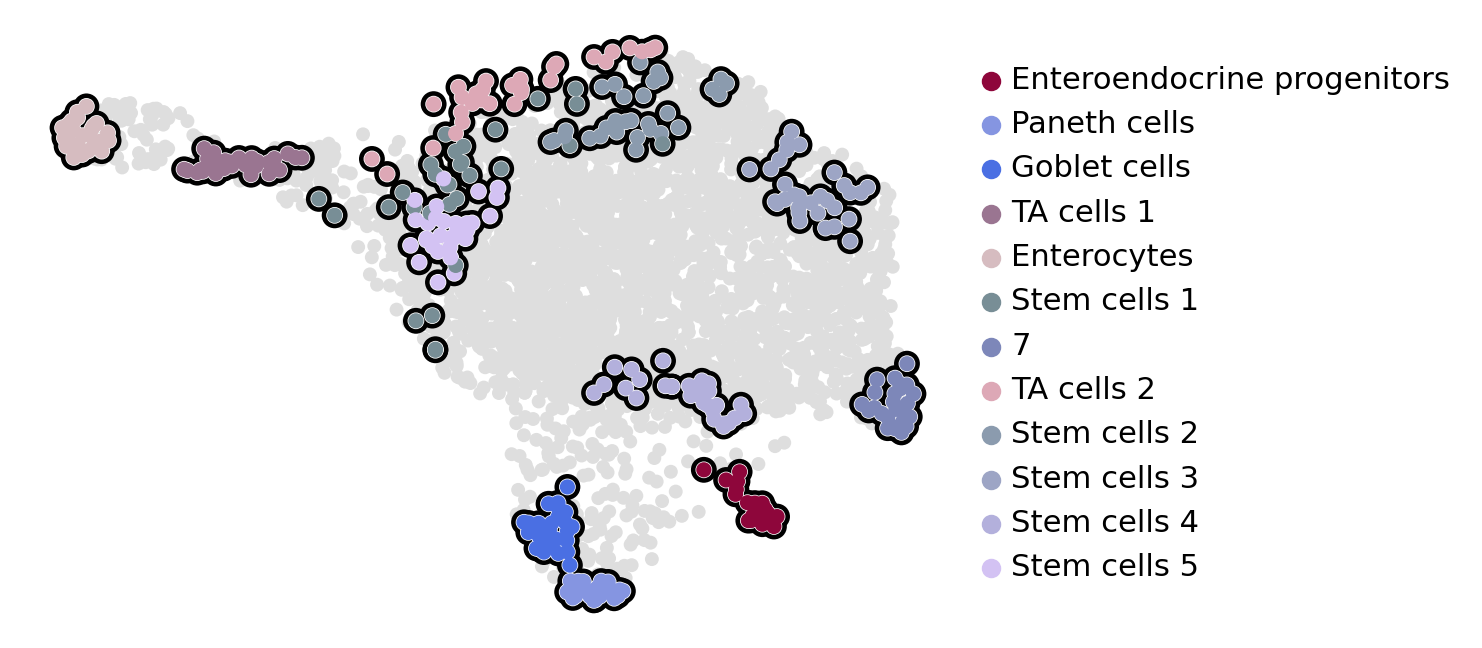

In [15]:
if running_in_notebook():
    plot_states(
        adata,
        estimator=estimator,
        which="macrostates",
        basis="umap",
        legend_loc="right",
        title="",
        size=100,
    )

## Pseudotime construction

### Identification of root cell

In [16]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9887503  0.9672722  0.96072364 0.931258   0.9118806
     0.8891967  0.8714203  0.84396434 0.8395355  0.8148398  0.8064168
     0.80334836 0.79723656 0.7871469 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:03)


In [17]:
_macrostates = estimator.macrostates.cat.categories.tolist()
adata.obs["stem_cell_1_cluster"] = (
    estimator.macrostates.astype(str).astype("category").cat.reorder_categories(["nan"] + _macrostates)
)
adata.obs.loc[~adata.obs["stem_cell_1_cluster"].isin(["Stem cells_1"]), "stem_cell_1_cluster"] = "nan"
adata.obs["stem_cell_1_cluster"] = (
    adata.obs["stem_cell_1_cluster"].astype(str).astype("category").cat.reorder_categories(["nan", "Stem cells_1"])
)

macrostates = estimator.macrostates.cat.categories.tolist()
macrostates_colors = adata.uns["macrostates_fwd_colors"]
adata.uns["stem_cell_1_cluster_colors"] = ["#dedede"] + [dict(zip(macrostates, macrostates_colors))["Stem cells_1"]]

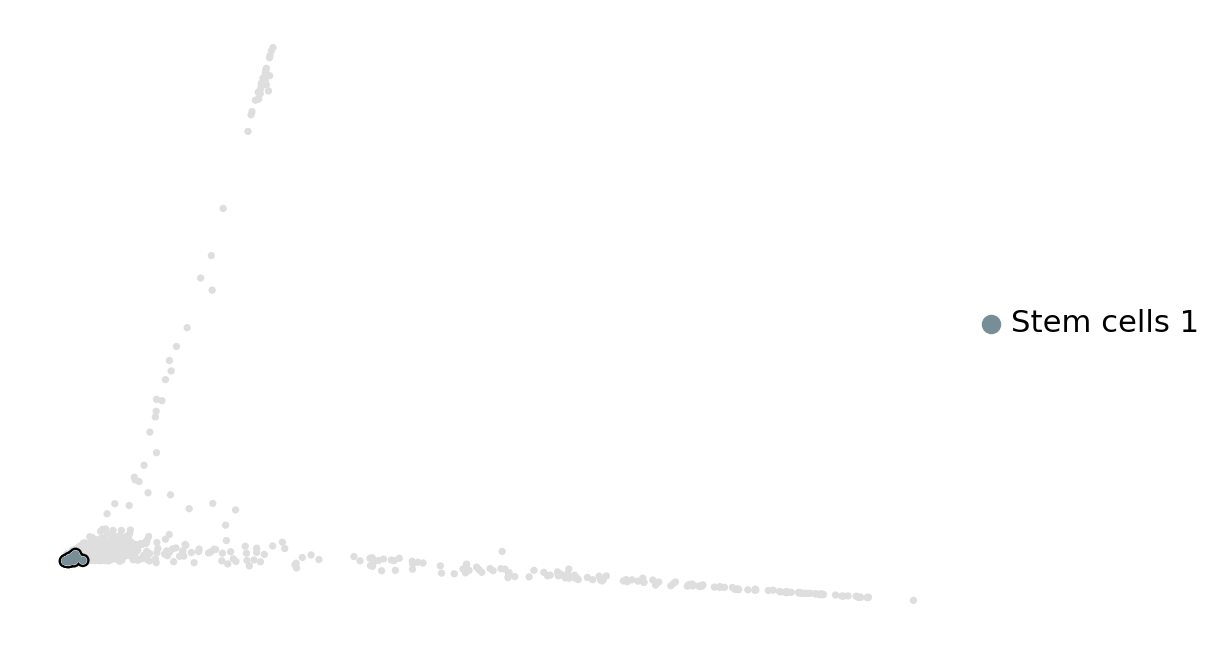

In [18]:
if running_in_notebook():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(
        adata,
        basis="diffmap",
        c=["stem_cell_1_cluster"],
        legend_loc="right",
        components=["2, 3"],
        add_outline="Stem cells_1",
        title="",
        ax=ax,
    )

if SAVE_FIGURES:
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(
        adata,
        basis="diffmap",
        c=["stem_cell_1_cluster"],
        legend_loc=False,
        components=["2, 3"],
        add_outline="Stem cells_1",
        title="",
        ax=ax,
    )

    fig.savefig(
        FIG_DIR / "labeling_kernel" / "diffmap_dc2_vs_dc3_stem_cells_1_outlined.pdf",
        format="pdf",
        transparent=True,
        bbox_inches="tight",
    )

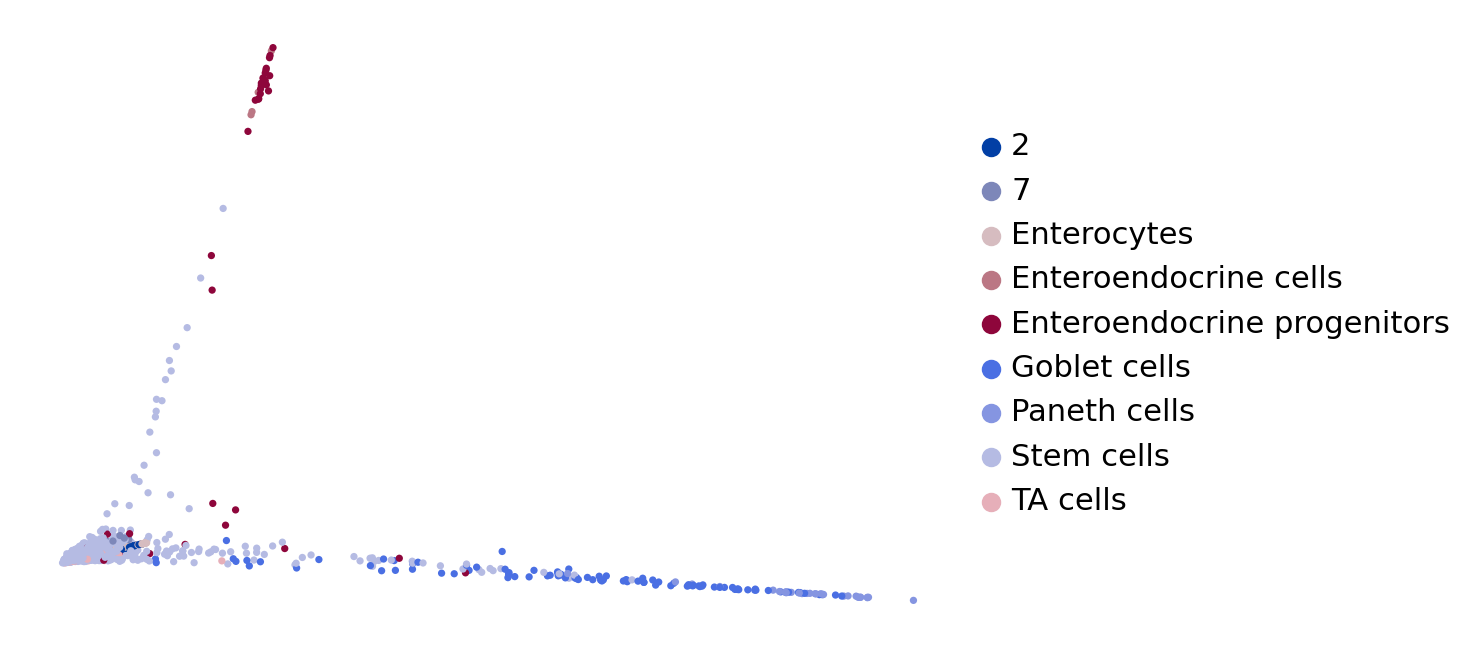

In [19]:
root_idx = adata.obsm["X_diffmap"][:, 2].argmin()
adata.uns["iroot"] = root_idx

if running_in_notebook():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="diffmap", c="cell_type", legend_loc="right", components=["2, 3"], title="", ax=ax)

if SAVE_FIGURES:
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="diffmap", c="cell_type", legend_loc=False, components=["2, 3"], title="", ax=ax)
    fig.savefig(
        FIG_DIR / "labeling_kernel" / "diffmap_dc2_vs_dc3_cell_types.eps",
        format="eps",
        transparent=True,
        bbox_inches="tight",
    )

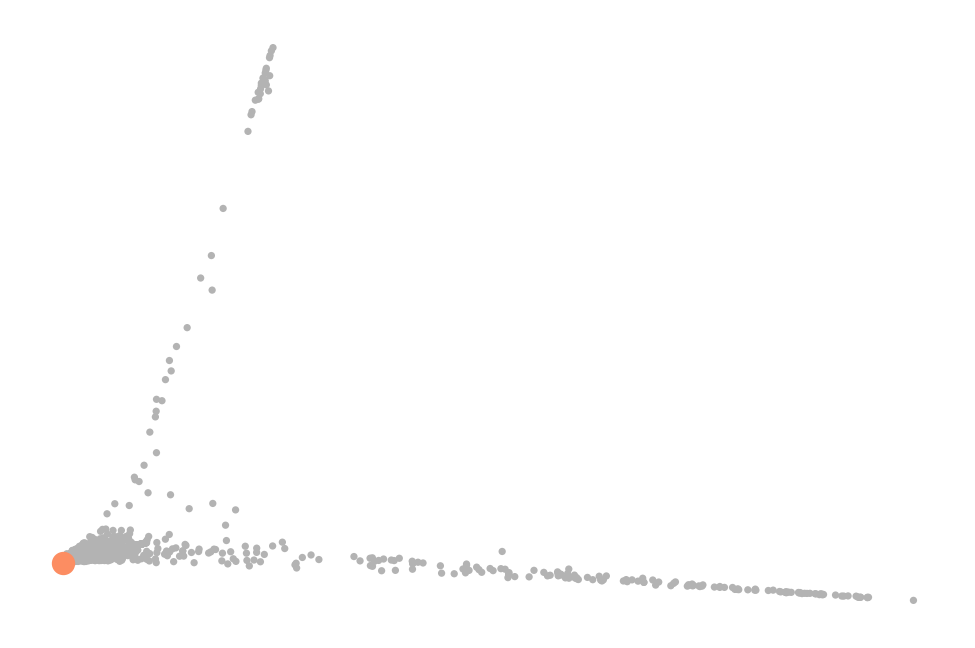

In [20]:
set2_cmap = sns.color_palette("Set2").as_hex()
palette = [set2_cmap[-1], set2_cmap[1]]

root_idx = adata.obsm["X_diffmap"][:, 2].argmin()
adata.uns["iroot"] = root_idx

if running_in_notebook():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="diffmap", c=root_idx, legend_loc=False, palette=palette, components=["2, 3"], ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / "labeling_kernel" / "diffmap_dc2_vs_dc3_pseudotime_root_id.eps",
        format="pdf",
        transparent=True,
        bbox_inches="tight",
    )

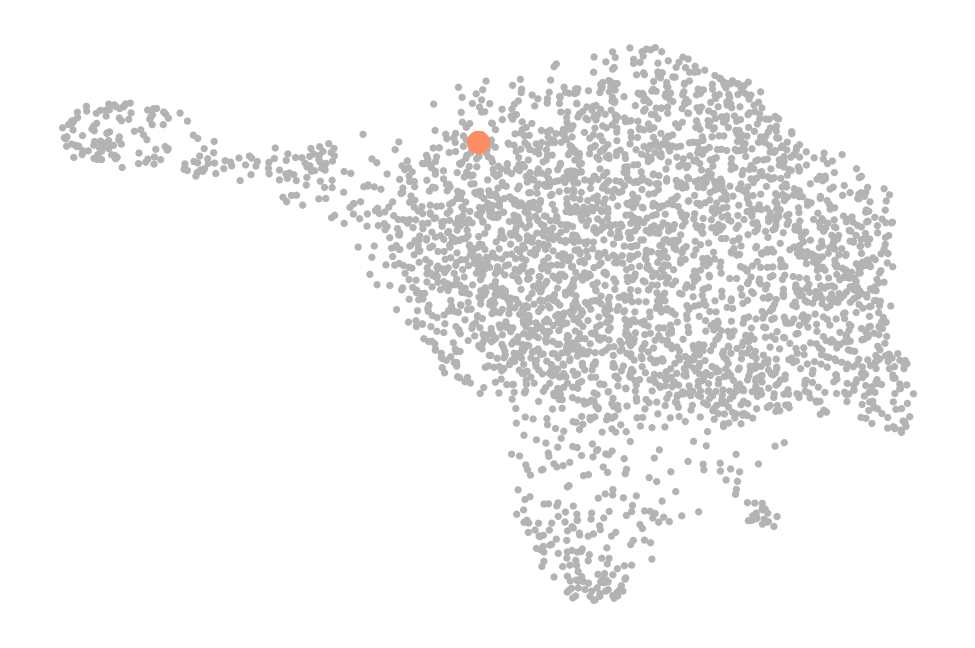

In [21]:
if running_in_notebook():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="umap", color=root_idx, palette=palette, color_map="viridis", ax=ax)
if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / "labeling_kernel" / "umap_pseudotime_root_id.eps",
        format="eps",
        transparent=True,
        bbox_inches="tight",
    )

### DPT pseudotime

In [22]:
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


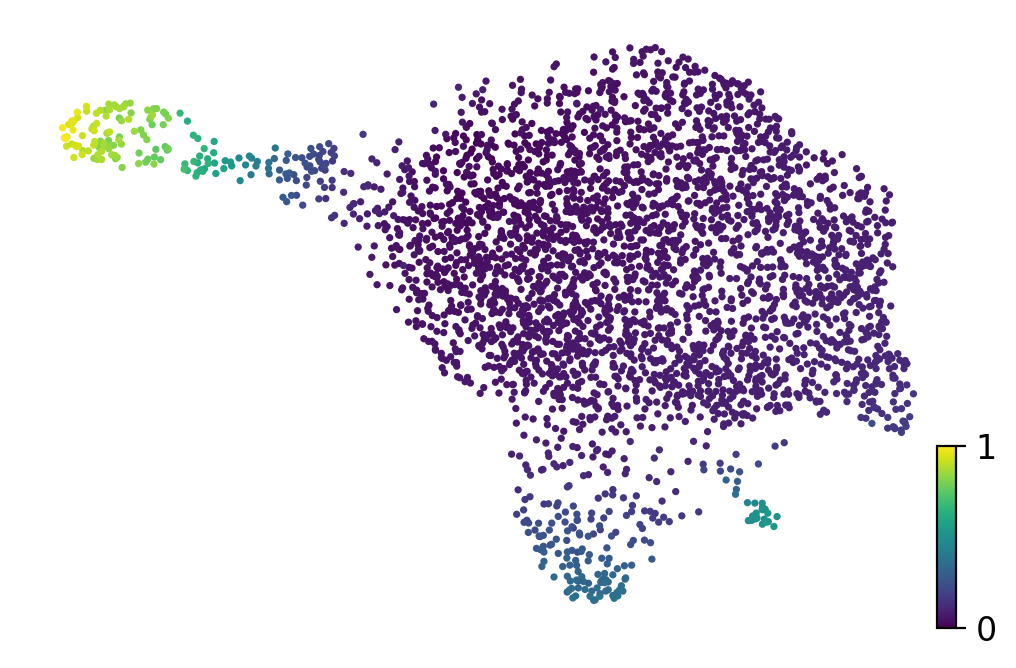

In [23]:
if running_in_notebook():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="umap", color="dpt_pseudotime", title="", color_map="viridis", ax=ax)

if SAVE_FIGURES:
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="umap", color="dpt_pseudotime", title="", color_map="viridis", colorbar=False, ax=ax)
    fig.savefig(
        FIG_DIR / "labeling_kernel" / "umap_colored_by_dpt_pseudotime.eps",
        format="eps",
        transparent=True,
        bbox_inches="tight",
    )

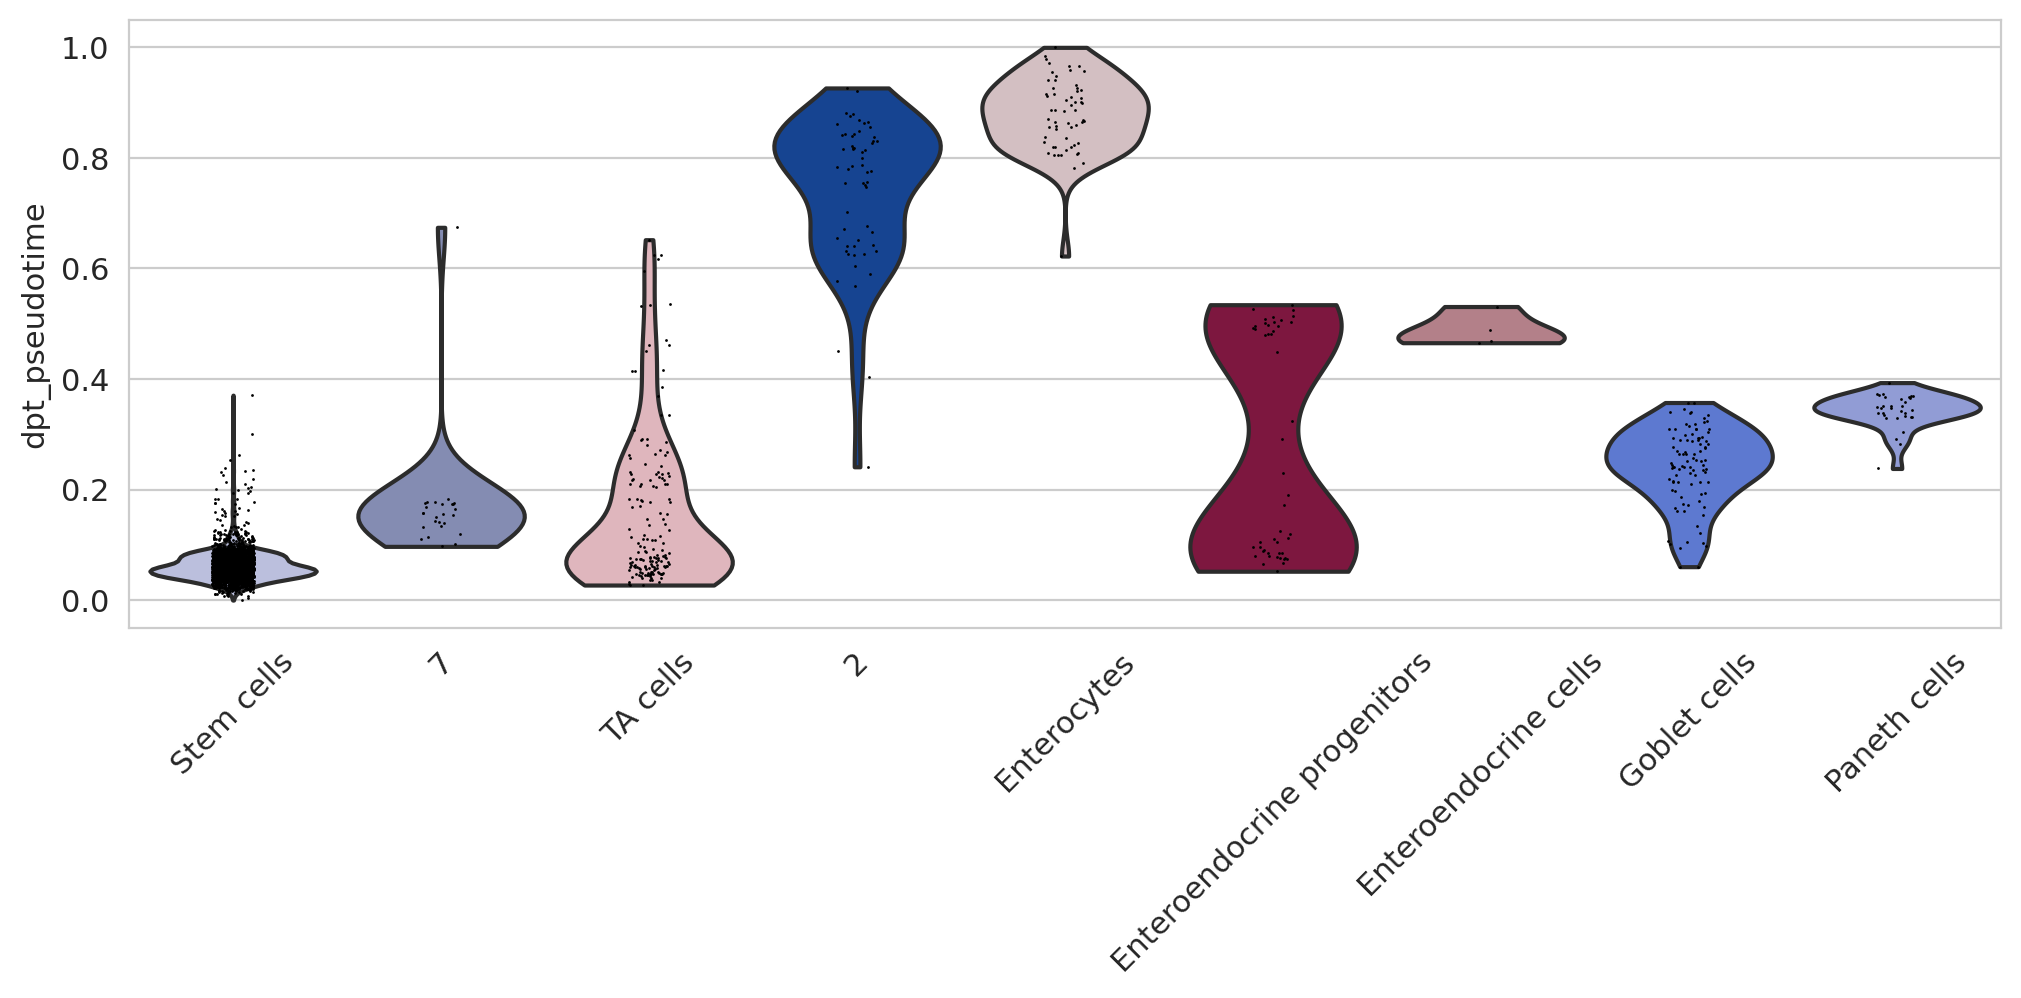

In [24]:
if running_in_notebook():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(12, 4))
    sc.pl.violin(
        adata,
        keys=["dpt_pseudotime"],
        groupby="cell_type",
        rotation=45,
        title="",
        legend_loc="none",
        order=[
            "Stem cells",
            "7",
            "TA cells",
            "2",
            "Enterocytes",
            "Enteroendocrine progenitors",
            "Enteroendocrine cells",
            "Goblet cells",
            "Paneth cells",
        ],
        ax=ax,
    )

if SAVE_FIGURES:
    ax.set(xticklabels=[])
    fig.savefig(
        FIG_DIR / "labeling_kernel" / "dpt_vs_cell_type.eps",
        format="eps",
        transparent=True,
        bbox_inches="tight",
    )

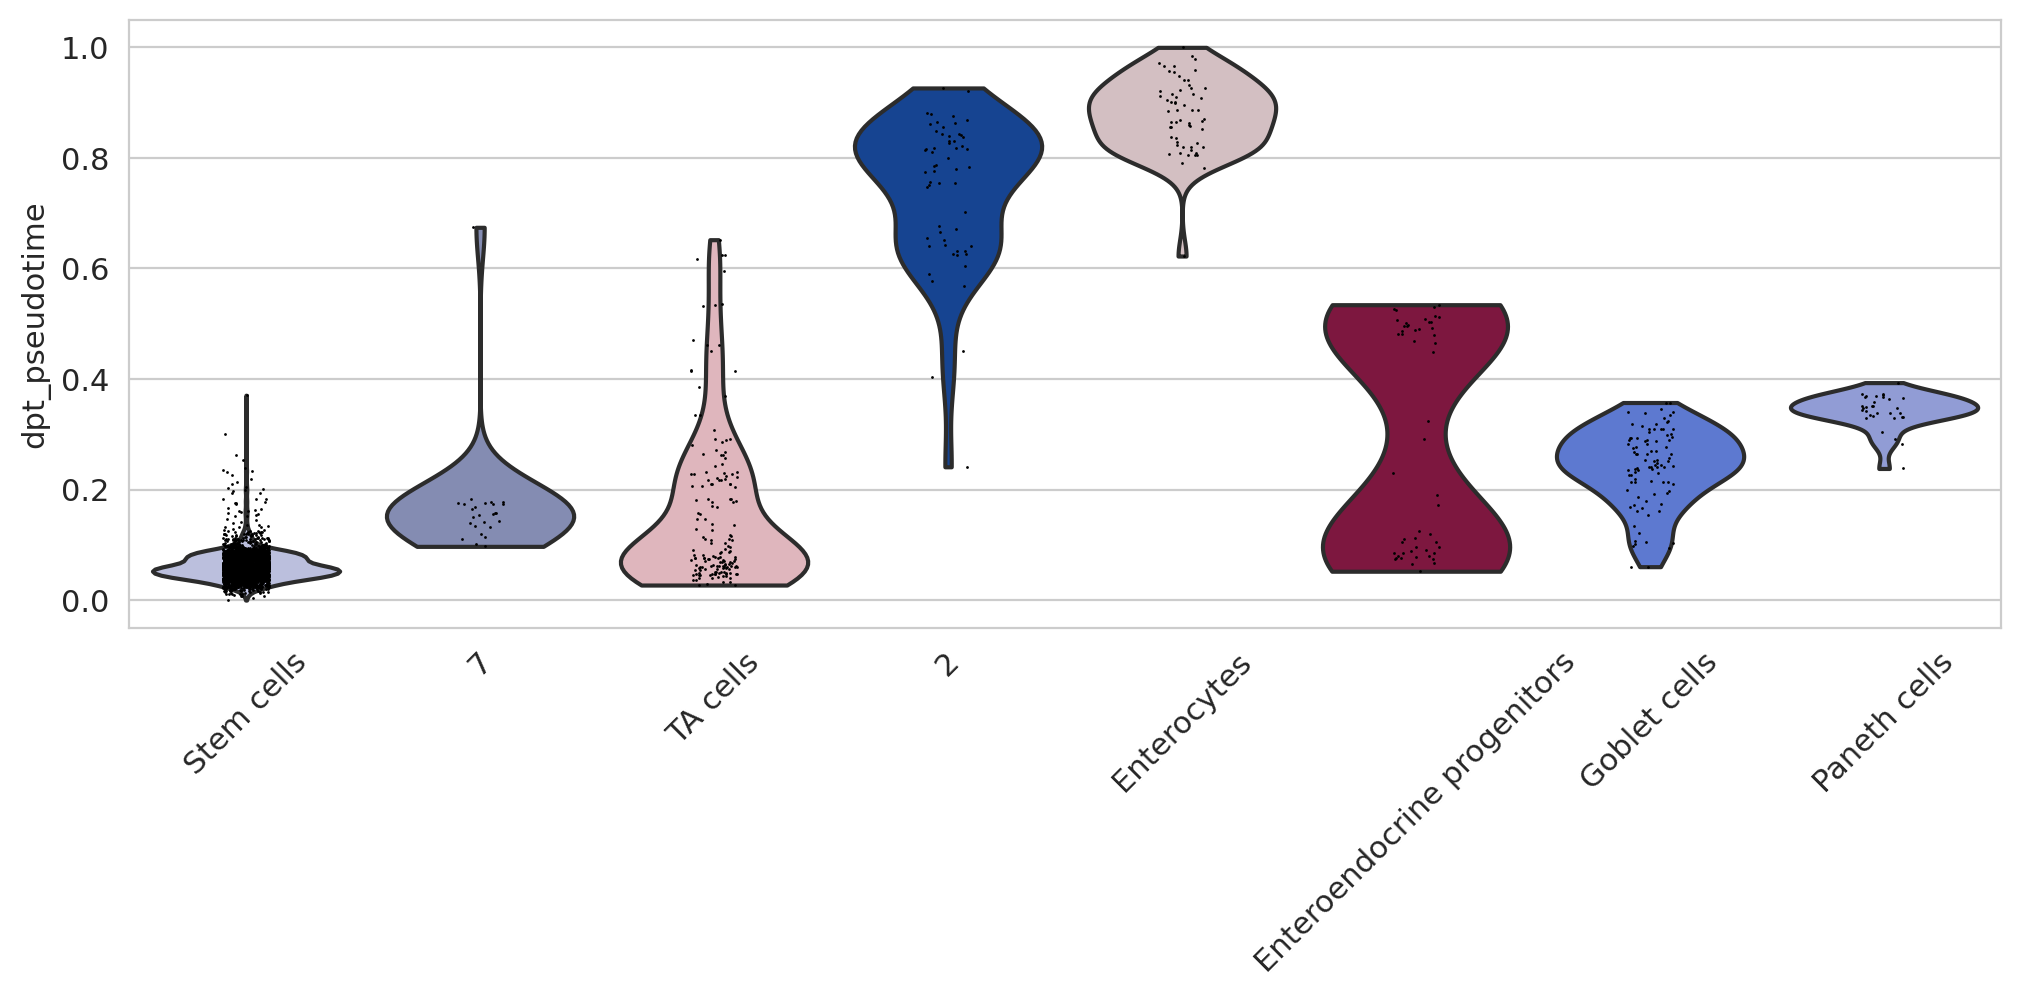

In [25]:
if running_in_notebook():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(12, 4))
    sc.pl.violin(
        adata,
        keys=["dpt_pseudotime"],
        groupby="cell_type_merged",
        rotation=45,
        title="",
        legend_loc="none",
        order=[
            "Stem cells",
            "7",
            "TA cells",
            "2",
            "Enterocytes",
            "Enteroendocrine progenitors",
            "Goblet cells",
            "Paneth cells",
        ],
        ax=ax,
    )

if SAVE_FIGURES:
    ax.set(xticklabels=[])
    fig.savefig(
        FIG_DIR / "labeling_kernel" / "dpt_vs_cell_type_merged.eps",
        format="eps",
        transparent=True,
        bbox_inches="tight",
    )

In [26]:
adata.obs["dpt_pseudotime"].to_csv(DATA_DIR / "sceu_organoid" / "results" / "dpt.csv")